In [1]:
import os
import torch
import scipy.io
import torch.nn as nn  # Import nn module
import torch.optim as optim  # Import optim module
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

from pnet import pNet

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
import os
import scipy.io
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class HyperspectralDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = []
        self.labels = []
        self.label_map = {}
        self.transform = transform

        species_dirs = os.listdir(root_dir)
        for idx, species in enumerate(species_dirs):
            species_dir = os.path.join(root_dir, species)
            if os.path.isdir(species_dir):
                self.label_map[species] = idx
                mat_files = [f for f in os.listdir(species_dir) if f.endswith('.mat')]
                for mat_file in mat_files:
                    file_path = os.path.join(species_dir, mat_file)
                    self.data.append(file_path)
                    self.labels.append(idx)
        
        print("Label mapping:", self.label_map)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mat_file = self.data[idx]
        label = self.labels[idx]

        # Load .mat file
        mat_contents = scipy.io.loadmat(mat_file)
        profile = mat_contents['profile']

        # Convert to PyTorch tensor
        profile = torch.tensor(profile, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            profile = self.transform(profile)

        return profile, label

    def get_image_path(self, idx):
        return self.data[idx]

    def set_transform(self, transform):
        self.transform = transform

def compute_statistics(dataset):
    all_profiles = []

    for i in range(len(dataset)):
        profile, _ = dataset[i]
        all_profiles.append(profile)

    all_profiles_tensor = torch.stack(all_profiles)
    channel_means = all_profiles_tensor.mean(dim=0)
    channel_stds = all_profiles_tensor.std(dim=0)

    return channel_means, channel_stds

class NormalizeProfile:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def __call__(self, profile):
        return (profile - self.mean) / self.std


In [3]:
# Function to get all file paths from a dataset
def get_all_file_paths(dataset):
    file_paths = []
    for idx in range(len(dataset)):
        file_paths.append(dataset.get_image_path(idx))
    return file_paths



# # Initialize the dataset with transformations
dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_all')

channel_means, channel_stds = compute_statistics(dataset)

# Define the custom transformation using the computed statistics
transform = NormalizeProfile(mean=channel_means.tolist(), std=channel_stds.tolist())

dataset.transform = transform


train_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_train', transform=transform)
test_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_test', transform=transform)
val_dataset = HyperspectralDataset(root_dir='../../resizedstuff/mst_resized_validation', transform=transform)


# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

Label mapping: {'Acinetobacter_baumanii': 0, 'Lactobacillus_casei': 1, 'Lactobacillus_jehnsenii': 2, 'Lactobacillus_gasseri': 3, 'Lactobacillus_delbrueckii': 4, 'Lactobacillus_salivarius': 5, 'Propionibacterium_acnes': 6, 'Lactobacillus_paracasei': 7, 'Bifidobacterium_spp': 8, 'Lactobacillus_reuteri': 9, 'Staphylococcus_aureus': 10, 'Escherichia_coli': 11, 'Lactobacillus_rhamnosus': 12, 'Lactobacillus_plantarum': 13, 'Enterococcus_faecium': 14, 'Porfyromonas_gingivalis': 15, 'Enterococcus_faecalis': 16, 'Micrococcus_spp': 17, 'Fusobacterium': 18, 'Actinomyces_israeli': 19, 'Lactobacillus_crispatus': 20, 'Clostridium_perfringens': 21, 'Staphylococcus_epidermidis': 22, 'Listeria_monocytogenes': 23, 'Pseudomonas_aeruginosa': 24, 'Lactobacillus_johnsonii': 25, 'Streptococcus_agalactiae': 26, 'Staphylococcus_saprophiticus': 27, 'Bacteroides_fragilis': 28, 'Neisseria_gonorrhoeae': 29, 'Veionella': 30, 'Proteus': 31, 'Candida_albicans': 32}
Label mapping: {'Acinetobacter_baumanii': 0, 'Lactob

In [4]:
# Get file paths for the main dataset and each split
main_dataset_paths = get_all_file_paths(dataset)
train_dataset_paths = get_all_file_paths(train_dataset)
val_dataset_paths = get_all_file_paths(val_dataset)
test_dataset_paths = get_all_file_paths(test_dataset)

# Check if the total length of the splits equals the length of the main dataset
total_split_length = len(train_dataset_paths) + len(val_dataset_paths) + len(test_dataset_paths)
if total_split_length != len(main_dataset_paths):
    print(f"Error: Total length of splits ({total_split_length}) does not equal length of main dataset ({len(main_dataset_paths)})")
else:
    print("Total length of splits matches the length of the main dataset.")

# Check for overlaps between splits
def check_for_overlaps(paths1, paths2):
    overlaps = set(paths1) & set(paths2)
    return overlaps

train_val_overlaps = check_for_overlaps(train_dataset_paths, val_dataset_paths)
train_test_overlaps = check_for_overlaps(train_dataset_paths, test_dataset_paths)
val_test_overlaps = check_for_overlaps(val_dataset_paths, test_dataset_paths)

if train_val_overlaps:
    print(f"Error: Overlaps found between train and validation datasets: {len(train_val_overlaps)} overlaps")
else:
    print("No overlaps found between train and validation datasets.")

if train_test_overlaps:
    print(f"Error: Overlaps found between train and test datasets: {len(train_test_overlaps)} overlaps")
else:
    print("No overlaps found between train and test datasets.")

if val_test_overlaps:
    print(f"Error: Overlaps found between validation and test datasets: {len(val_test_overlaps)} overlaps")
else:
    print("No overlaps found between validation and test datasets.")

Total length of splits matches the length of the main dataset.
No overlaps found between train and validation datasets.
No overlaps found between train and test datasets.
No overlaps found between validation and test datasets.


In [5]:
model = pNet().to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

In [7]:
# Initialize lists to store the metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
lr_change_epochs = []

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler based on validation loss and track LR changes
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        lr_change_epochs.append(epoch)
        print(f"Learning rate reduced from {old_lr} to {new_lr}")


Epoch [1/200], Loss: 3.4374, Training Accuracy: 10.45%
Validation Loss: 3.4270, Validation Accuracy: 10.53%
Epoch [2/200], Loss: 3.3553, Training Accuracy: 19.40%
Validation Loss: 3.3450, Validation Accuracy: 23.68%
Epoch [3/200], Loss: 3.3248, Training Accuracy: 22.20%
Validation Loss: 3.3444, Validation Accuracy: 19.74%
Epoch [4/200], Loss: 3.3322, Training Accuracy: 21.46%
Validation Loss: 3.3928, Validation Accuracy: 14.47%
Epoch [5/200], Loss: 3.3022, Training Accuracy: 24.25%
Validation Loss: 3.2946, Validation Accuracy: 25.00%
Epoch [6/200], Loss: 3.2808, Training Accuracy: 26.87%
Validation Loss: 3.3326, Validation Accuracy: 21.05%
Epoch [7/200], Loss: 3.2970, Training Accuracy: 24.81%
Validation Loss: 3.3185, Validation Accuracy: 22.37%
Epoch [8/200], Loss: 3.2715, Training Accuracy: 27.05%
Validation Loss: 3.2582, Validation Accuracy: 28.95%
Epoch [9/200], Loss: 3.2779, Training Accuracy: 27.24%
Validation Loss: 3.2734, Validation Accuracy: 27.63%
Epoch [10/200], Loss: 3.2719

KeyboardInterrupt: 

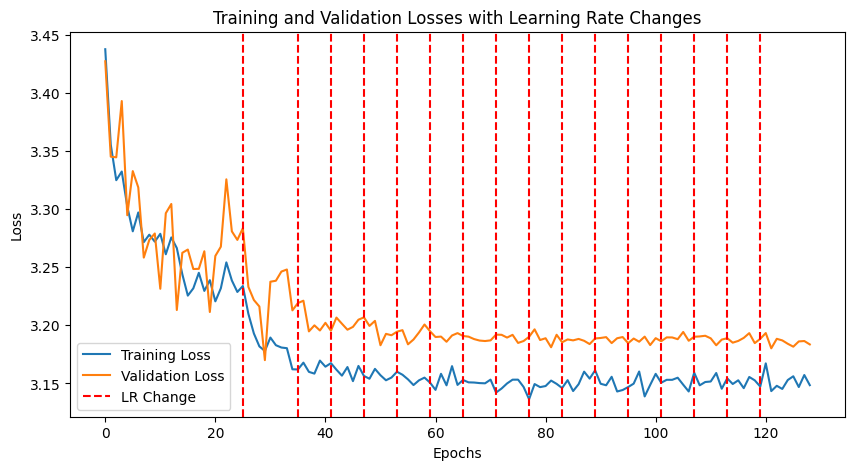

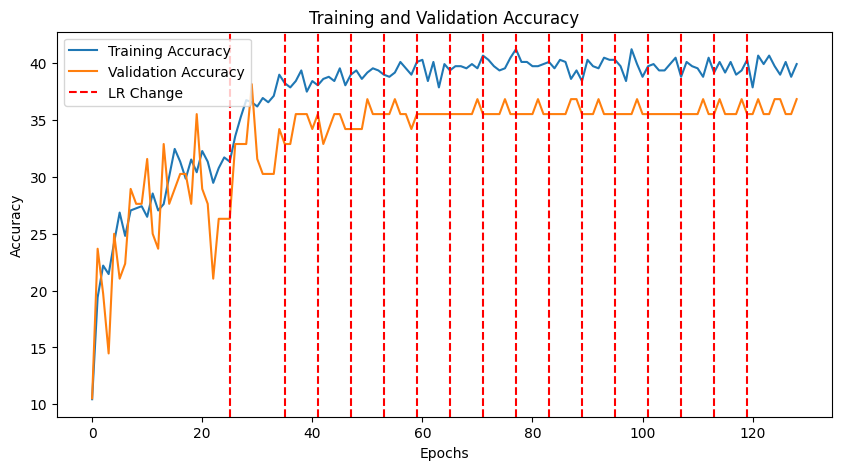

In [8]:
# Plot the training and validation losses with learning rate change points
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses with Learning Rate Changes')
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
for lr_epoch in lr_change_epochs:
    plt.axvline(x=lr_epoch, color='r', linestyle='--', label='LR Change' if lr_epoch == lr_change_epochs[0] else "")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [9]:
torch.save(model.state_dict(), 'pnet.pth')

In [10]:
for name, param in model.named_parameters():
    print(name)

conv1.weight
conv1.bias
batch_norm1.weight
batch_norm1.bias
dense1.weight
dense1.bias
dense2.weight
dense2.bias
